In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


# INTRODUCTION
Crime analysis is the review of data collected and/or stored in order to identify trends of criminal activities so that the 
law enforcement can effectively adjust to deter that crime and continue to protect the public’s safety.The process of crime 
analysis involve five basic steps; collection, categorization, analysis, dissemination, and evaluation of information(S R Stiles 1981).
For this project we will focus on one of the stage of the process involve in crime analysis which is 'analysis', other 4 stages are not applicable to this project. The benefit of analysis stage involve identifing patterns, predict future trends, and develop strategies for preventing and combating crimes.


# Approach used
The dataset was filtered by Crime types mentioned and the fall within city mentioned to see the count of the reported cases between these two instances. Additionally, the top 5 crime types and top 5 fall within (cities) with the highest crimes was indentified. Each of the top 5 fall within was analyzed to know the top 5 crime type in each cities, this is an effort to establish the relatedness between the crime types and fall within(cities).
The dataset was then analyzed by grouping across the month and the year to determine the trend of the number of the cases reported between 2010 and 2021. 

# Data overview
 The data include data for united kingdom crimes from the year 2010 to 2021. the first step is to understand the data set, and ensure that the data include all neccesary columns of information and ensure the data is correctly formatted and of good quality.
We will start by importing dependencies and reading the data from the .gzip file to a dataframe.

In [2]:
# import neccessary libraries
import pyspark
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# creating a session in PySpark
from pyspark.sql import SparkSession

In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("CourseWork").getOrCreate()

In [5]:
# Importing the Crime Data gzip file into a DataFrame
main_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("codec", "gzip").load(r"C:\Users\richa\Desktop\Data project\Crime_Data_Analysis\working data\all_crimes21_hdr.txt.gz")

In [45]:
# Get the count of the dataset
main_df.select(count("*")).show()

+--------+
|count(1)|
+--------+
|65078250|
+--------+



In [10]:
# check first 5 of the data
main_df.show(5)

+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12-01

Some columns are not needed for the analysis,drop the columns and move the columns of interet forward for analysis 

In [11]:
# Select columns of interest from the dataset
selected_column = main_df.select(['Month','Reported by','Falls within','Longitude','Latitude','Location','LSOA code','LSOA name',
 'Crime type', 'Last outcome category'])
selected_column.show(5)

+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+
|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|
+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+
|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|
|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|
|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E

In [12]:
# checking the column datatypes
selected_column.dtypes

[('Month', 'timestamp'),
 ('Reported by', 'string'),
 ('Falls within', 'string'),
 ('Longitude', 'double'),
 ('Latitude', 'double'),
 ('Location', 'string'),
 ('LSOA code', 'string'),
 ('LSOA name', 'string'),
 ('Crime type', 'string'),
 ('Last outcome category', 'string')]

In [13]:
#making a copy of the data for preprocessing 
dataframe = selected_column
dataframe.show(2)

+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+
|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|
+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+
|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|
|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|
+-------------------+--------------------+--------------------+---------+---------+--------------------+-

Extract year and month from the month_ column and they are stored in two different columns in order to understand the crime rate.

In [14]:
#import F from the pyspark library
from pyspark.sql import functions as F

dataframe = dataframe.withColumn('Month_', F.to_date(F.col('Month')))

# Extract the month and year from the 'timestamp' column
dataframe_month = dataframe.withColumn('month', F.month('Month_'))
dataframe_year = dataframe_month.withColumn('year', F.year('Month_'))

#the new dataset after the columns have been added
dataframe_year.show()

+-----+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+----------+----+
|month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|    Month_|year|
+-----+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+----------+----+
|   12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|2010-12-01|2010|
|   12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|2010-12-01|2010|
|   12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E0101

In [29]:
# Group the DataFrame by the 'year'
dataframe_yeargrouped = dataframe_year.groupBy(['year'])

# Use the count() function to count the number of rows in each group
dataframe_yearcounts = dataframe_yeargrouped.agg(F.count('*').alias('count'))

# Show the resulting DataFrame
dataframe_yearcounts.show()

+----+-------+
|year|  count|
+----+-------+
|2018|6589193|
|2015|5753958|
|2013|5764867|
|2014|5656675|
|2019|6525046|
|2020|6359716|
|2012|6123968|
|2016|6072143|
|2010| 474341|
|2011|6730113|
|2017|6593491|
|2021|2434739|
+----+-------+



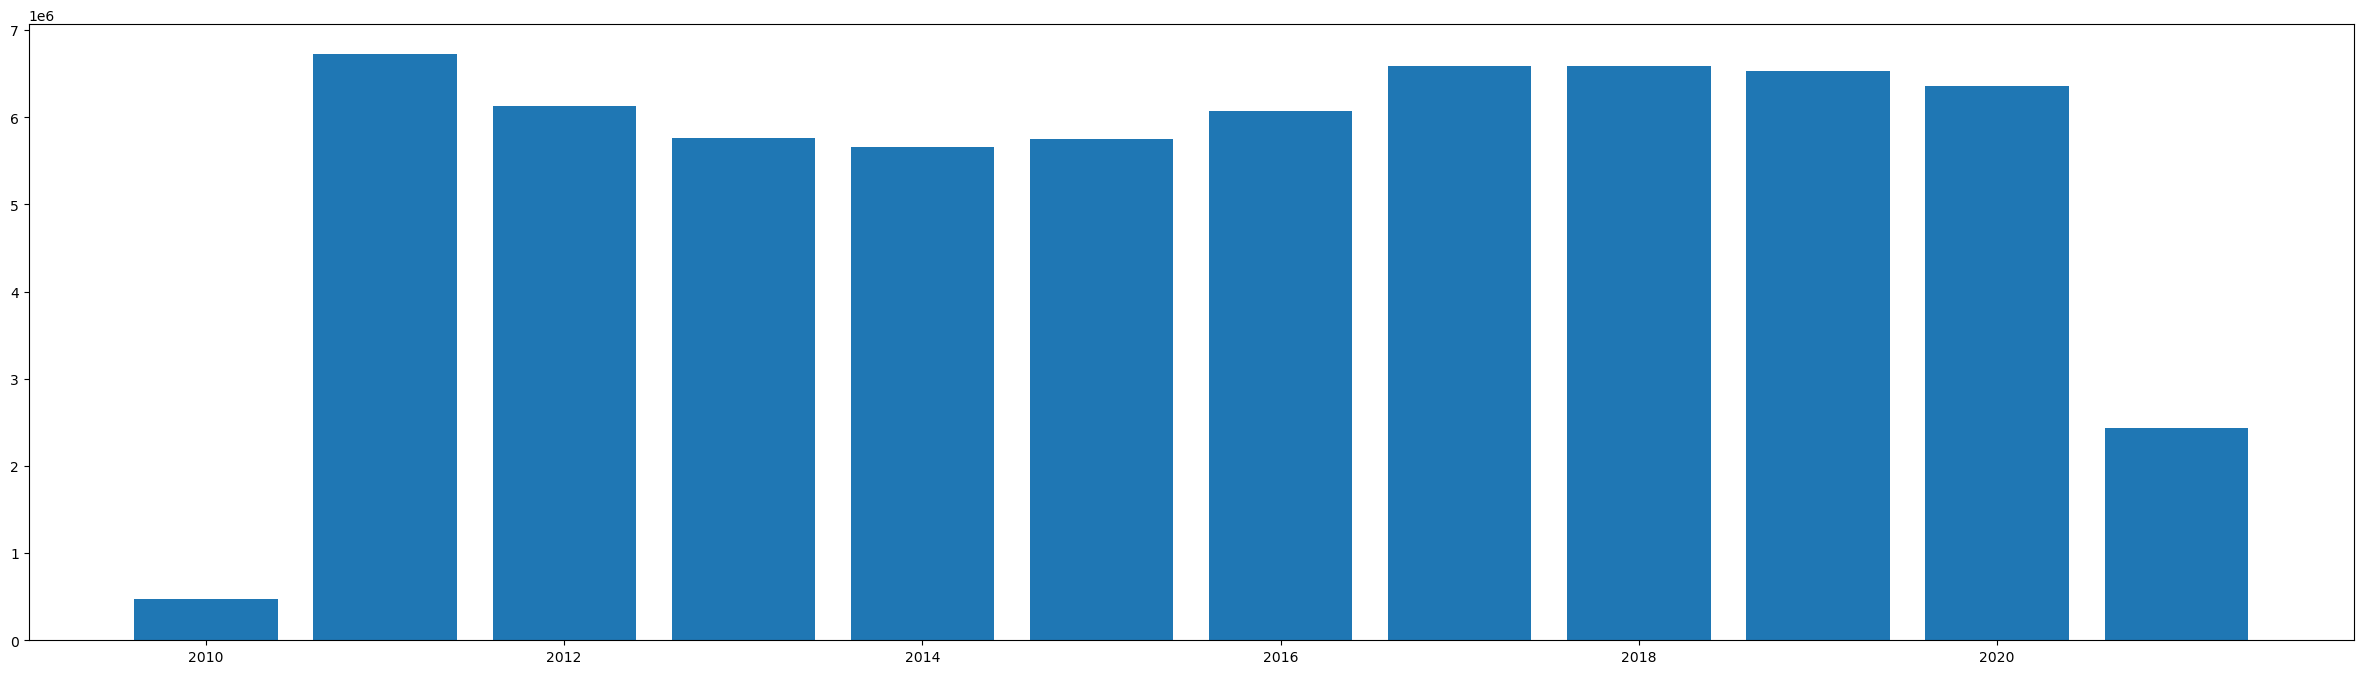

In [30]:
# Convert the Spark DataFrame to a Pandas DataFrame( analyzing anti-social behaviour data)
yearlydf_pd = dataframe_yearcounts.toPandas()
    
# Set the labels for the x-axis
x_labels = yearlydf_pd["year"]

# Set the values for the y-axis
y_values = yearlydf_pd["count"]

# Set the figure size
plt.figure(figsize=(30, 8))

# Create the bar chart
plt.bar(x_labels, y_values)

# Show the plot
plt.show()

In [31]:
# Group the DataFrame by the 'month' and 'year' columns
dataframe_grouped = dataframe_year.groupBy(['month', 'year'])

# Use the count() function to count the number of rows in each group
dataframe_counts = dataframe_grouped.agg(F.count('*').alias('count'))

# Concatenate the 'column_month' and 'column_year' columns with a space as the separator
concatdataframe_counts = dataframe_counts.withColumn('month_year', F.concat(F.col('month'), F.lit('/'), F.col('year')))

# Show the resulting DataFrame
concatdataframe_counts.show()

+-----+----+------+----------+
|month|year| count|month_year|
+-----+----+------+----------+
|    6|2016|516782|    6/2016|
|    8|2012|559232|    8/2012|
|    1|2016|450925|    1/2016|
|    1|2017|488613|    1/2017|
|    7|2018|593535|    7/2018|
|   12|2013|428745|   12/2013|
|    2|2014|405568|    2/2014|
|    3|2017|557370|    3/2017|
|    8|2013|533925|    8/2013|
|   11|2016|499889|   11/2016|
|    6|2018|568561|    6/2018|
|    3|2018|531306|    3/2018|
|    6|2019|571709|    6/2019|
|   12|2020|469974|   12/2020|
|    9|2014|491827|    9/2014|
|    9|2019|520832|    9/2019|
|   11|2020|509881|   11/2020|
|    4|2021|491377|    4/2021|
|    2|2016|441241|    2/2016|
|    4|2019|560115|    4/2019|
+-----+----+------+----------+
only showing top 20 rows



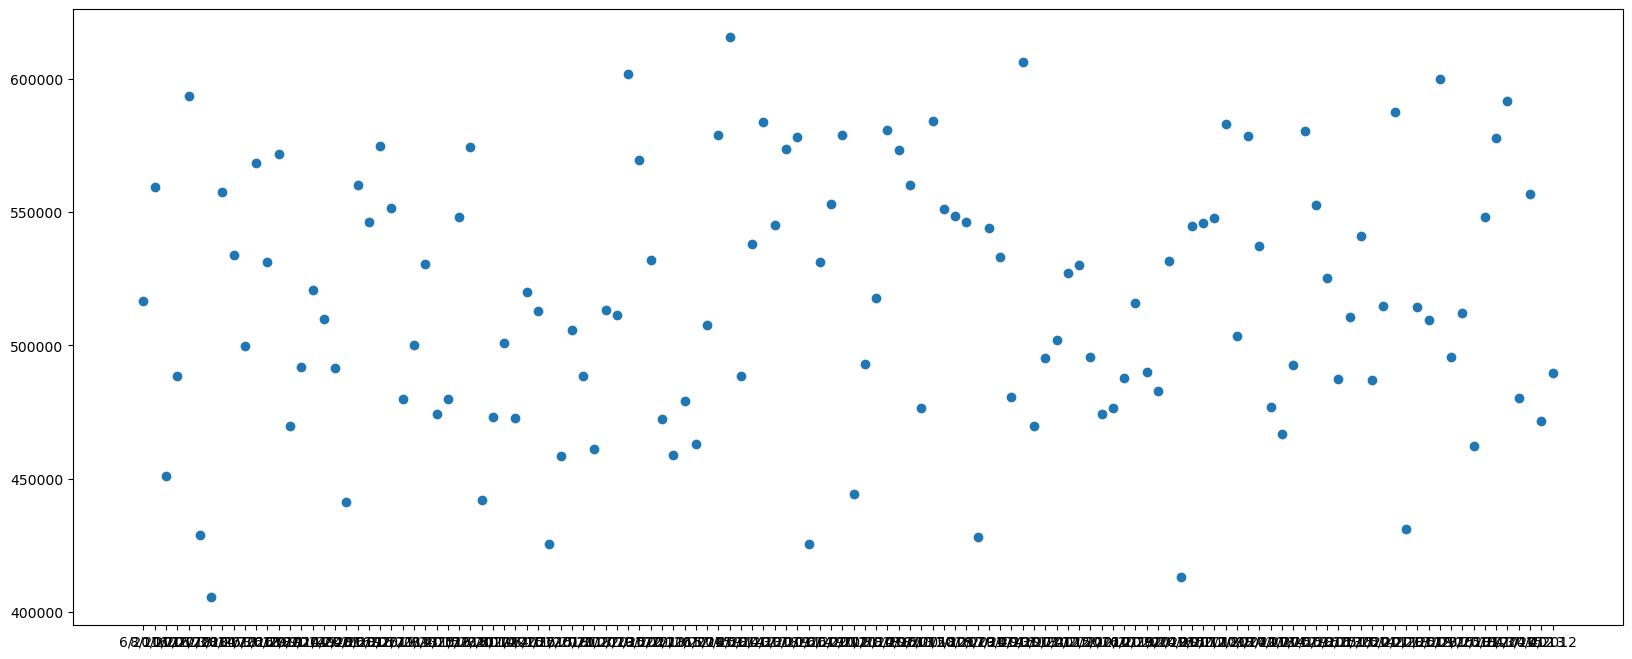

In [32]:
# Convert the Spark DataFrame to a Pandas DataFrame( yearly crime rate)
concatdataframe_counts_pd = concatdataframe_counts.toPandas()
    
# Set the labels for the x-axis
x_labels = concatdataframe_counts_pd["month_year"]

# Set the values for the y-axis
y_values = concatdataframe_counts_pd["count"]

# Set the figure size
plt.figure(figsize=(20, 8))

# Create the scatter plot
plt.scatter(x_labels, y_values)

# Show the plot
plt.show()

# count of crime related to each distinct crime_type

In [33]:
# getting the unique values in the crime type column
from pyspark.sql.functions import count

# Group the data by case type and count the number of crimes committed for each case type
caseTypeCounts = dataframe.groupBy("crime type").agg(count("*").alias("count"))

# Get the distinct case types and their corresponding count of crimes
distinctCaseTypes = caseTypeCounts.select("crime type", "count").distinct()

# Print the unique values to the console in desending order
distinctCaseTypes.sort("count", ascending=False).show(truncate=False)


+----------------------------+--------+
|crime type                  |count   |
+----------------------------+--------+
|Anti-social behaviour       |20211528|
|Violence and sexual offences|11411540|
|Criminal damage and arson   |5343182 |
|Other theft                 |5206259 |
|Burglary                    |4350252 |
|Vehicle crime               |4170769 |
|Shoplifting                 |3227557 |
|Other crime                 |2565111 |
|Public order                |2564695 |
|Drugs                       |1682486 |
|Violent crime               |1673219 |
|Bicycle theft               |735689  |
|Theft from the person       |714621  |
|Robbery                     |696008  |
|Possession of weapons       |283189  |
|Public disorder and weapons |242145  |
+----------------------------+--------+



In [34]:
# Group the data by case type and count the number of crimes committed for each case type
caseTypeCounts = dataframe.groupBy("crime type").agg(count("*").alias("count"))

# Get the distinct case types and their corresponding count of crimes
distinctCaseTypes = caseTypeCounts.select("crime type", "count").distinct()

# Print the unique values to the console in desending order
distinctCaseTypes.sort("count", ascending=False).show(5)

+--------------------+--------+
|          crime type|   count|
+--------------------+--------+
|Anti-social behav...|20211528|
|Violence and sexu...|11411540|
|Criminal damage a...| 5343182|
|         Other theft| 5206259|
|            Burglary| 4350252|
+--------------------+--------+
only showing top 5 rows



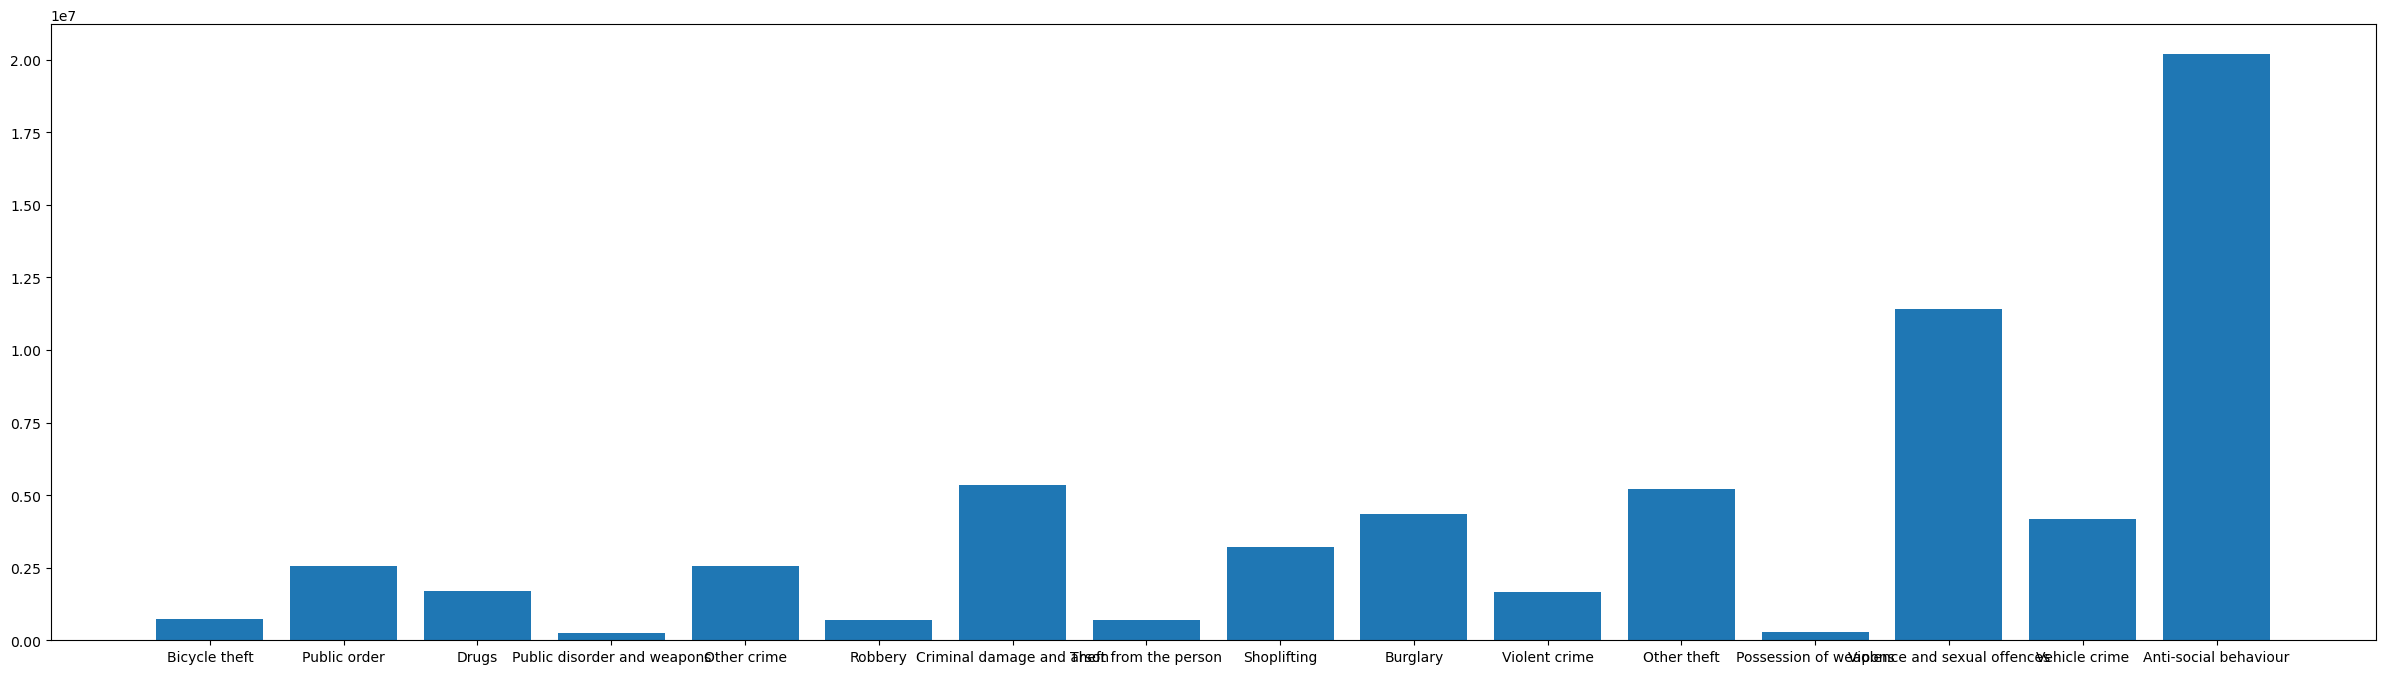

In [35]:
# Import the required libraries
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
df_pd = distinctCaseTypes.toPandas()

# Set the labels for the x-axis
x_labels = df_pd["crime type"]

# Set the values for the y-axis
y_values = df_pd["count"]

# Set the figure size
plt.figure(figsize=(30, 8))

# Create the bar chart
plt.bar(x_labels, y_values)

# Show the plot
plt.show()

# falls within and their corresponding count of crimes

In [36]:
# Group the data by falls within and count the number of crimes committed for each
FallWithinCounts = dataframe.groupBy("Falls within").agg(count("*").alias("count"))

# Get the distinct falls within and their corresponding count of crimes
distinctFallWithin = FallWithinCounts.select("Falls within").distinct()

# Get the count of distinct falls within
distinctFallWithin.select(count("*")).show()

+--------+
|count(1)|
+--------+
|      45|
+--------+



In [37]:
# Filter the data to include only crimes that are classified as "Anti-social behaviour"
filteredData = dataframe.filter(dataframe["crime type"] == "Anti-social behaviour")

# Group the data by falls within and count the number of crimes 
# committed in each falls within in relation to max crime type(Anti-social behaviour)
fallswithincrimeCounts = filteredData.groupBy("Falls within").agg(count("*").alias("count"))

# Sort the results in descending order by the "count" column
sortedfallswithincrimeCounts = fallswithincrimeCounts.sort("count", ascending=False)

# Display the sorted results
sortedfallswithincrimeCounts.show(truncate=False)

+----------------------------------+-------+
|Falls within                      |count  |
+----------------------------------+-------+
|Metropolitan Police Service       |3056160|
|Greater Manchester Police         |954137 |
|Lancashire Constabulary           |836168 |
|West Yorkshire Police             |750148 |
|South Yorkshire Police            |730102 |
|Northumbria Police                |723955 |
|West Midlands Police              |679949 |
|Police Service of Northern Ireland|606823 |
|Hampshire Constabulary            |601833 |
|Essex Police                      |547691 |
|Merseyside Police                 |531094 |
|Sussex Police                     |528721 |
|Kent Police                       |505044 |
|Avon and Somerset Constabulary    |500579 |
|Devon & Cornwall Police           |478433 |
|West Mercia Police                |465391 |
|Derbyshire Constabulary           |455062 |
|South Wales Police                |447595 |
|Cleveland Police                  |420476 |
|Nottingha

In [38]:
# Group the data by falls within and count the number of crimes committed for each
FallWithinCounts = dataframe.groupBy("Falls within").agg(count("*").alias("count"))

# Get the distinct falls within and their corresponding count of crimes
distinctFallWithin = FallWithinCounts.select("Falls within", "count").distinct()

# Print the unique values to the console in desending order
distinctFallWithin.sort("count", ascending=False).show(5, truncate=False)

+---------------------------+--------+
|Falls within               |count   |
+---------------------------+--------+
|Metropolitan Police Service|11161303|
|West Yorkshire Police      |3082846 |
|Greater Manchester Police  |3034429 |
|West Midlands Police       |2883885 |
|Lancashire Constabulary    |2029443 |
+---------------------------+--------+
only showing top 5 rows



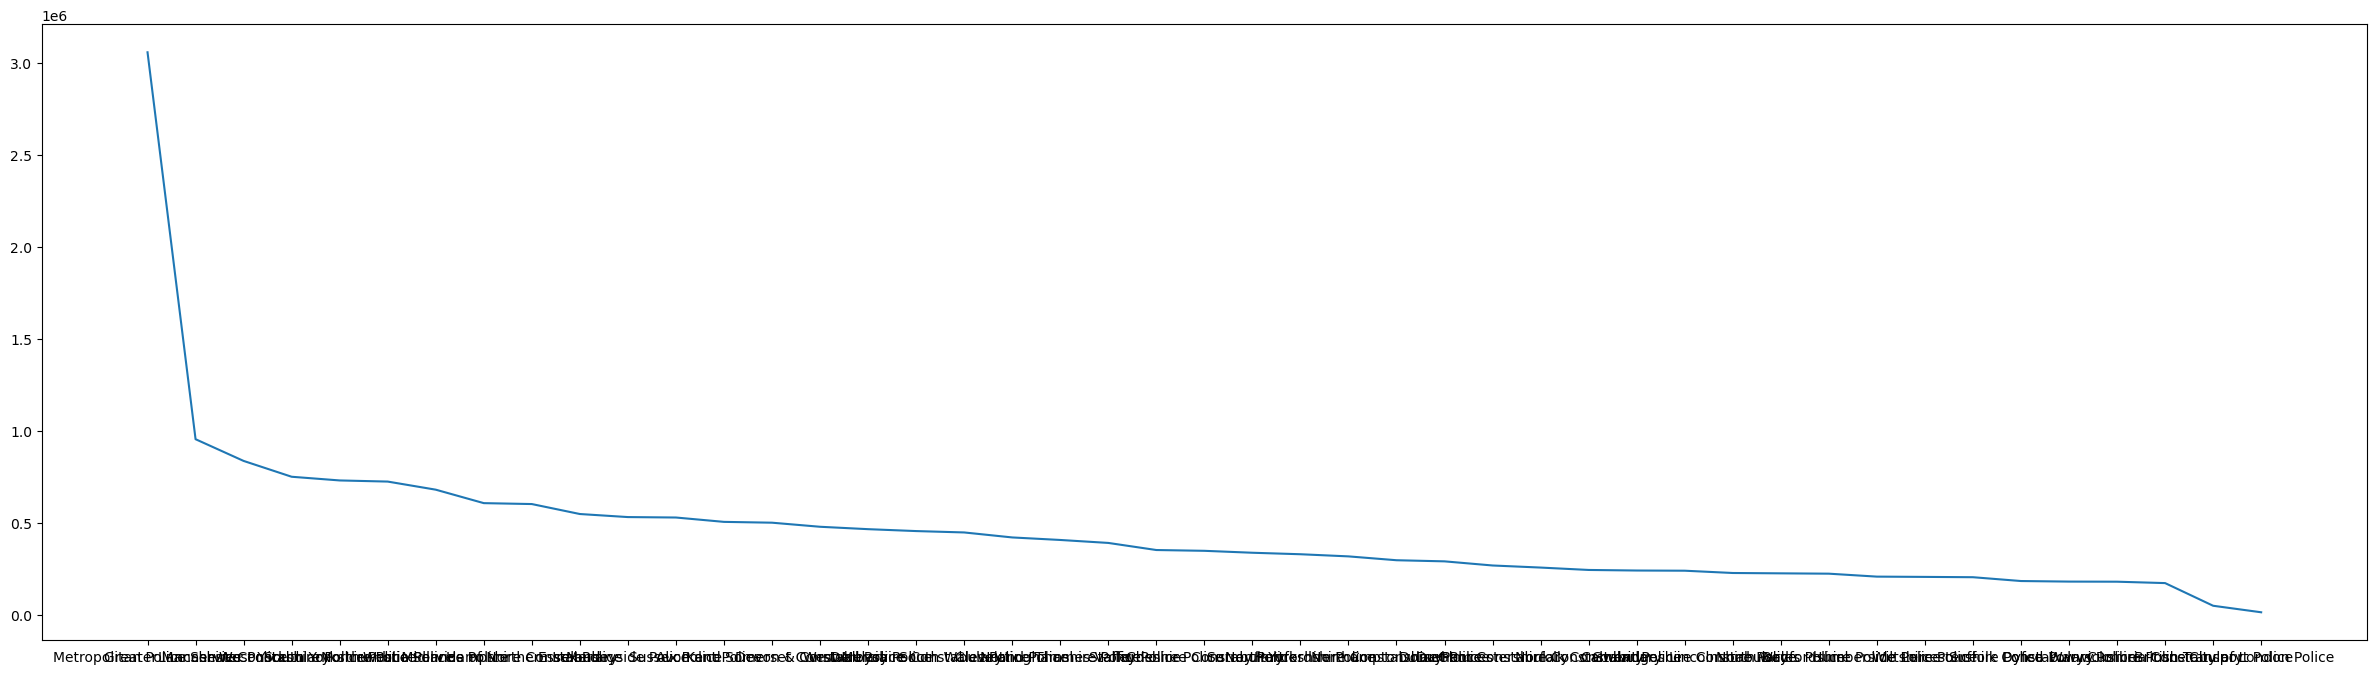

In [39]:
# Convert the Spark DataFrame to a Pandas DataFrame( analyzing anti-social behaviour data)
crimecountdf_pd = sortedfallswithincrimeCounts.toPandas()
    
# Set the labels for the x-axis
x_labels = crimecountdf_pd["Falls within"]

# Set the values for the y-axis
y_values = crimecountdf_pd["count"]

# Set the figure size
plt.figure(figsize=(30, 8))

# Create the line chart
plt.plot(x_labels, y_values)

# Show the plot
plt.show()

In [40]:
# Filter the data to include only crimes that fall within "Metropolitan Police"
filteredData = dataframe.filter(dataframe["Falls within"] == "Metropolitan Police Service")

# Group the data by crime type and count the number of the crime that fall within(Metropolitan Police Service)
fallswithincrimeCounts = filteredData.groupBy("crime type").agg(count("*").alias("count"))

# Sort the results in descending order by the "count" column
sortedfallswithincrimeCounts = fallswithincrimeCounts.sort("count", ascending=False)

# Display the sorted results
sortedfallswithincrimeCounts.show(5, truncate=False)

+----------------------------+-------+
|crime type                  |count  |
+----------------------------+-------+
|Anti-social behaviour       |3056160|
|Violence and sexual offences|1660849|
|Other theft                 |1180973|
|Vehicle crime               |1030964|
|Burglary                    |819823 |
+----------------------------+-------+
only showing top 5 rows



In [41]:
# Filter the data to include only crimes that fall within "Greater Manchester Police"
filteredData = dataframe.filter(dataframe["Falls within"] == "Greater Manchester Police")

# Group the data by crime type and count the number of the crime that fall within(Greater Manchester Police)
fallswithincrimeCounts = filteredData.groupBy("crime type").agg(count("*").alias("count"))

# Sort the results in descending order by the "count" column
sortedfallswithincrimeCounts = fallswithincrimeCounts.sort("count", ascending=False)

# Display the sorted results
sortedfallswithincrimeCounts.show(5, truncate=False)

+----------------------------+------+
|crime type                  |count |
+----------------------------+------+
|Anti-social behaviour       |954137|
|Violence and sexual offences|450824|
|Criminal damage and arson   |263752|
|Burglary                    |254007|
|Vehicle crime               |214788|
+----------------------------+------+
only showing top 5 rows



In [42]:
# Filter the data to include only crimes that fall within "Lancashire Constabulary"
filteredData = dataframe.filter(dataframe["Falls within"] == "Lancashire Constabulary")

# Group the data by crime type and count the number of the crime that fall within(Lancashire Constabulary)
fallswithincrimeCounts = filteredData.groupBy("crime type").agg(count("*").alias("count"))

# Sort the results in descending order by the "count" column
sortedfallswithincrimeCounts = fallswithincrimeCounts.sort("count", ascending=False)

# Display the sorted results
sortedfallswithincrimeCounts.show(5, truncate=False)

+----------------------------+------+
|crime type                  |count |
+----------------------------+------+
|Anti-social behaviour       |836168|
|Violence and sexual offences|352363|
|Criminal damage and arson   |168401|
|Other theft                 |140634|
|Burglary                    |123398|
+----------------------------+------+
only showing top 5 rows



In [43]:
# Filter the data to include only crimes that fall within "West Yorkshire Police"
filteredData = dataframe.filter(dataframe["Falls within"] == "West Yorkshire Police")

# Group the data by crime type and count the number of the crime that fall within(West Yorkshire Police)
fallswithincrimeCounts = filteredData.groupBy("crime type").agg(count("*").alias("count"))

# Sort the results in descending order by the "count" column
sortedfallswithincrimeCounts = fallswithincrimeCounts.sort("count", ascending=False)

# Display the sorted results
sortedfallswithincrimeCounts.show(5, truncate=False)

+----------------------------+------+
|crime type                  |count |
+----------------------------+------+
|Anti-social behaviour       |750148|
|Violence and sexual offences|643257|
|Criminal damage and arson   |276191|
|Burglary                    |264169|
|Other theft                 |253392|
+----------------------------+------+
only showing top 5 rows



In [44]:
# Filter the data to include only crimes that fall within "West Midlands Police"
filteredData = dataframe.filter(dataframe["Falls within"] == "West Midlands Police")

# Group the data by crime type and count the number of the crime that fall within(West Midlands Police)
fallswithincrimeCounts = filteredData.groupBy("crime type").agg(count("*").alias("count"))

# Sort the results in descending order by the "count" column
sortedfallswithincrimeCounts = fallswithincrimeCounts.sort("count", ascending=False)

# Display the sorted results
sortedfallswithincrimeCounts.show(5, truncate=False)

+----------------------------+------+
|crime type                  |count |
+----------------------------+------+
|Anti-social behaviour       |679949|
|Violence and sexual offences|554355|
|Vehicle crime               |292444|
|Burglary                    |255895|
|Criminal damage and arson   |239455|
+----------------------------+------+
only showing top 5 rows

